## Imports

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer ## for handling the missing values
import seaborn as sns ## for data visualization
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Get CSV File 

In [37]:
filepath = '../data/California_Houses.csv'
df = pd.read_csv(filepath)

### Print 1st 5 Rows using head

In [38]:
print(df.columns.tolist())
print(df.head())
print(df.shape)

['Median_House_Value', 'Median_Income', 'Median_Age', 'Tot_Rooms', 'Tot_Bedrooms', 'Population', 'Households', 'Latitude', 'Longitude', 'Distance_to_coast', 'Distance_to_LA', 'Distance_to_SanDiego', 'Distance_to_SanJose', 'Distance_to_SanFrancisco']
   Median_House_Value  Median_Income  Median_Age  Tot_Rooms  Tot_Bedrooms  \
0            452600.0         8.3252          41        880           129   
1            358500.0         8.3014          21       7099          1106   
2            352100.0         7.2574          52       1467           190   
3            341300.0         5.6431          52       1274           235   
4            342200.0         3.8462          52       1627           280   

   Population  Households  Latitude  Longitude  Distance_to_coast  \
0         322         126     37.88    -122.23        9263.040773   
1        2401        1138     37.86    -122.22       10225.733072   
2         496         177     37.85    -122.24        8259.085109   
3         5

### Before Training the model, make sure there are no missing values in your dataset

In [39]:
print(df.isnull().sum())
## All values were zero meaning there are no null values in this dataset

Median_House_Value          0
Median_Income               0
Median_Age                  0
Tot_Rooms                   0
Tot_Bedrooms                0
Population                  0
Households                  0
Latitude                    0
Longitude                   0
Distance_to_coast           0
Distance_to_LA              0
Distance_to_SanDiego        0
Distance_to_SanJose         0
Distance_to_SanFrancisco    0
dtype: int64


### Separate Features and Target Value

Mean House Value:  206855.81690891474


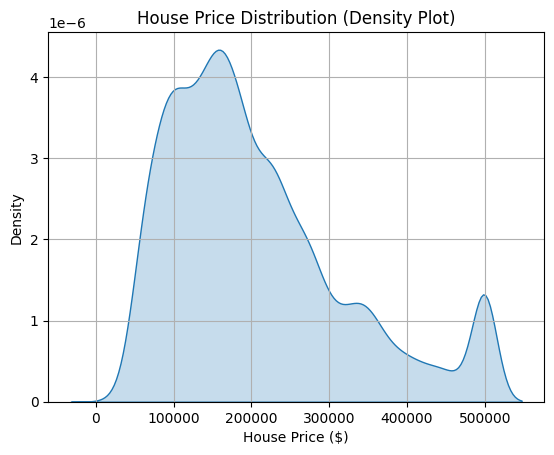

In [40]:
X= df.drop("Median_House_Value",axis=1)
# drop the target column(median house value) and leaving only the independent features

y=df["Median_House_Value"]
# y is the target value

print("Mean House Value: ",y.mean())

sns.kdeplot(data=df,x="Median_House_Value",fill=True)

plt.xlabel("House Price ($)")
plt.ylabel("Density")
plt.title("House Price Distribution (Density Plot)")
plt.grid(True)
plt.show()

Notice that there are some Outliers might need to exlude them to improve the accuracy

# Data Splitting

In [41]:
X_train, X_temp,y_train,y_temp=train_test_split(X,y,test_size=0.30,random_state=42)

# train_test_split is used to split dataset into a training set and a temporary one
# to use again to split it to validation and test sets
X_validation,X_test,y_validation,y_test=train_test_split(X_temp,y_temp,test_size=0.5,random_state=42)

print(X_train.shape)
print(y_train.shape) ## i want it to be (m,1)

(14448, 13)
(14448,)


In [42]:
##Reshape
y_train = np.array(y_train).reshape(-1, 1)
y_validation=np.array(y_validation).reshape(-1,1)
y_test=np.array(y_test).reshape(-1,1) # -1 means take the number of rows as it's 

print(y_train.shape)

(14448, 1)


## Scaling the data


In [43]:
# Scaling training
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

## Manual Linear Regression Implementation

In [84]:
def predict(X, w,b=None):
    # Compute predictions
    if b is None:
        X_b = np.hstack((np.ones((X.shape[0], 1)), X))
        return np.dot(X_b, w)
    else:
        return np.dot(X, w) + b
    

### Functions to Compute MAE , MSE

In [45]:
def compute_mae_cost(X,y,w,b):
    m = X.shape[0]
    y_pred=predict(X,w,b)
    
    # Calculate MAE (Mean Absolute Error)
    mae_cost = (1 / m) * np.sum(np.abs(y_pred - y))
    return mae_cost

def compute_mse_cost(X,y,w,b):
    m = X.shape[0]
    y_pred=predict(X,w,b)
    
    # Calculate MSE (Mean Square Error)
    mse_cost=(1 / (2*m) * np.sum((y_pred - y)** 2))
    return mse_cost

### Find Optimum Weights using Direct Solution

In [86]:
def normal_equation(X,y):
    X_b = np.hstack((np.ones((X.shape[0], 1)), X))  # (m, n+1)
    # Compute weights (w = (XᵀX)⁻¹Xᵀy)
    w = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
    return w

### Functions to Compute Gradient Descent

In [92]:
def compute_gradient(X,y,w,b):
    m=X.shape[0]
    y_pred=predict(X,w,b)
    dw = (1 / m) * np.dot(X.T, (y_pred - y))   # (n, 1)
    db = (1 / m) * np.sum(y_pred - y)         
    return dw, db
    

def gradient_descent(X,y,w,b,alpha,num_iterations):
    #update weights to minimize the cost
    mse_cost_history=[]
    
    for i in range(num_iterations):
        dw,db=compute_gradient(X,y,w,b)
        w = w - alpha * dw
        b = b - alpha * db
        mae_cost =compute_mae_cost(X,y,w,b)
        mse_cost =compute_mse_cost(X,y,w,b)
        mse_cost_history.append(mse_cost)
    
        # if i % 100 == 0:
        #     print(f"Iteration {i}, MSE Cost: {mse_cost:.4f},MAE Cost: {mae_cost:.4f}")
    return w,b,mse_cost_history

# Linear Regression Model Manually

In [90]:
def train_model(X,y,alpha,num_epochs):
    m,n=X.shape
    w=np.zeros((n,1))
    b=0
    w,b,cost_history=gradient_descent(X,y,w,b,alpha,num_iterations=num_epochs)
    return w,b,cost_history

def evaluate_model(X_test,y_test,w,b=None):
    #to compute MSE, MAE ON Test set after training
    y_pred=predict(X_test,w,b)
    mse=np.mean((y_test-y_pred)**2)
    mae=np.mean(np.abs(y_test-y_pred))
    return mse,mae


### Manual Linear Regression using Direct Solution to find Optimum weights

In [91]:
w_normal=normal_equation(X_train_scaled,y_train)

# Predict
y_pred_train=predict(X_train_scaled,w_normal)
y_pred_val=predict(X_validation_scaled,w_normal)
y_pred_test=predict(X_test_scaled,w_normal)

mse_train,mae_train=evaluate_model(X_train_scaled,y_train,w_normal)
mse_val,mae_val=evaluate_model(X_validation_scaled,y_validation,w_normal)
mse_test,mae_test=evaluate_model(X_test_scaled,y_test,w_normal)

print("Linear Regression (Manual Implementation) Performance:")
print(f"Train MSE: {mse_train:.2f},  MAE: {mae_train:.2f}")
print(f"Validation MSE: {mse_val:.2f},  MAE: {mae_val:.2f}")
print(f"Test MSE: {mse_test:.2f},  MAE: {mae_test:.2f}")

Linear Regression (Manual Implementation) Performance:
Train MSE: 4730358742.50,  MAE: 49927.00
Validation MSE: 4907211997.37,  MAE: 50790.06
Test MSE: 4400953150.61,  MAE: 48782.03


### Manual Linear Regression using Gradient Descent to find Optimum weights

In [100]:
alpha=0.2
num_iterations=10000

# Train
w,b,cost_history=train_model(X_train_scaled,y_train,alpha,num_iterations)

### Evaluate Manual Linear Regression
mse_train,mae_train=evaluate_model(X_train_scaled,y_train,w,b)
mse_val,mae_val=evaluate_model(X_validation_scaled,y_validation,w,b)
mse_test,mae_test=evaluate_model(X_test_scaled,y_test,w,b)

print("Linear Regression (Manual Implementation) Performance:")
print(f"Train MSE: {mse_train:.2f},  MAE: {mae_train:.2f}")
print(f"Validation MSE: {mse_val:.2f},  MAE: {mae_val:.2f}")
print(f"Test MSE: {mse_test:.2f},  MAE: {mae_test:.2f}")

Linear Regression (Manual Implementation) Performance:
Train MSE: 4730361972.26,  MAE: 49927.89
Validation MSE: 4907210127.71,  MAE: 50790.86
Test MSE: 4400806185.90,  MAE: 48782.53


# Linear Regression Model (Using Scikit-Learn)

In [79]:
#  Train the Linear Regression model
lin_reg_sk = LinearRegression()
lin_reg_sk.fit(X_train_scaled, y_train)

#  Predictions
y_pred_train_lin_sk = lin_reg_sk.predict(X_train_scaled)
y_pred_val_lin_sk   = lin_reg_sk.predict(X_validation_scaled)
y_pred_test_lin_sk  = lin_reg_sk.predict(X_test_scaled)

#  Compute mse - mae
mse_train_lin_sk = mean_squared_error(y_train, y_pred_train_lin_sk)
mae_train_lin_sk = mean_absolute_error(y_train, y_pred_train_lin_sk)

mse_val_lin_sk = mean_squared_error(y_validation, y_pred_val_lin_sk)
mae_val_lin_sk = mean_absolute_error(y_validation, y_pred_val_lin_sk)

mse_test_lin_sk = mean_squared_error(y_test, y_pred_test_lin_sk)
mae_test_lin_sk = mean_absolute_error(y_test, y_pred_test_lin_sk)

#  Display results of linear regression - STANDARD
print("Linear Regression (Scikit-Learn) Performance:")
print(f"Train MSE: {mse_train_lin_sk:.2f},  MAE: {mae_train_lin_sk:.2f}")
print(f"Validation MSE: {mse_val_lin_sk:.2f},  MAE: {mae_val_lin_sk:.2f}")
print(f"Test MSE: {mse_test_lin_sk:.2f},  MAE: {mae_test_lin_sk:.2f}")

Linear Regression (Scikit-Learn) Performance:
Train MSE: 4730358742.50,  MAE: 49927.00
Validation MSE: 4907211997.37,  MAE: 50790.06
Test MSE: 4400953150.61,  MAE: 48782.03


### Comparing the Performance of Sickit-Learn and Manual Implementation

> Linear Regression (Scikit-Learn) Performance:
1. Train MSE: 4730358742.50,  MAE: 49927.00
2. Validation MSE: 4907211997.37,  MAE: 50790.06
3. Test MSE: 4400953150.61,  MAE: 48782.03

>Linear Regression (Manual Implementation) Performance:
1. Train MSE: 4730358742.50,  MAE: 49927.00
2. Validation MSE: 4907211997.37,  MAE: 50790.06
3. Test MSE: 4400953150.61,  MAE: 48782.03

Results are quite close

# Ridge Regression — Validation Error vs. α

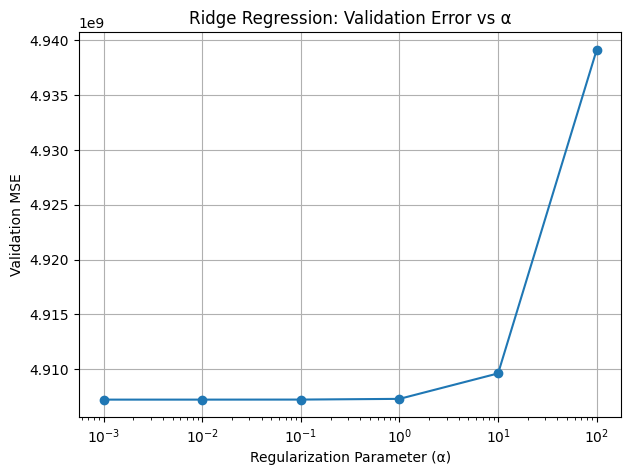

In [ ]:
# imports needed
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
# ridge regression -> for regularization & overfitting the model
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_mse = []
ridge_mae = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_scaled, y_train)
    y_pred_val = ridge.predict(X_validation_scaled)
    
    ridge_mse.append(mean_squared_error(y_validation, y_pred_val))
    ridge_mae.append(mean_absolute_error(y_validation, y_pred_val))

# Plot mse vs alpha
plt.figure(figsize=(7,5))
plt.plot(alphas, ridge_mse, marker='o')
plt.xscale('log')
plt.title("Ridge Regression: Validation Error vs α")
plt.xlabel("Regularization Parameter (α)")
plt.ylabel("Validation MSE")
plt.grid(True)
plt.show()


# Lasso Regression — Validation Error vs. α

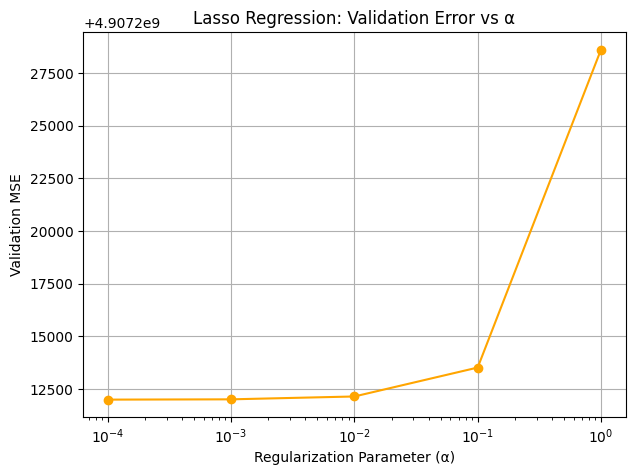

In [ ]:
# imports needed
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
# lasso regression -> for regularization of absolute weights
alphas = [0.0001, 0.001, 0.01, 0.1, 1]
lasso_mse = []
lasso_mae = []

for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    y_pred_val = lasso.predict(X_validation_scaled)
    
    lasso_mse.append(mean_squared_error(y_validation, y_pred_val))
    lasso_mae.append(mean_absolute_error(y_validation, y_pred_val))

# Plot mse vs alpha
plt.figure(figsize=(7,5))
plt.plot(alphas, lasso_mse, marker='o', color='orange')
plt.xscale('log')
plt.title("Lasso Regression: Validation Error vs α")
plt.xlabel("Regularization Parameter (α)")
plt.ylabel("Validation MSE")
plt.grid(True)
plt.show()
